In [15]:
import numpy as np
import torch
import clip
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter

from src.clip_video_response import clip_video_response
from src.clip_video_response import convert_mp4_to_imgs
from src.sam_wrapper import sam_wrapper

In [12]:
path = "..\\data\\videos\\23043.mp4"
video_frames, num_frames = convert_mp4_to_imgs(path, 512)
sampling_rate = 1000

video_frames, num_frames = video_frames[::sampling_rate], num_frames//sampling_rate

# Note: uncomment if you want to view the video, otherwise leave commented.
# Embedding videos into notebook can cause UI to slow down
# Video(path, embed=True)

In [16]:
checkpoint = "..\data\pytorch_checkpoints\SAM\sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_wrapper(checkpoint, model_type, device)

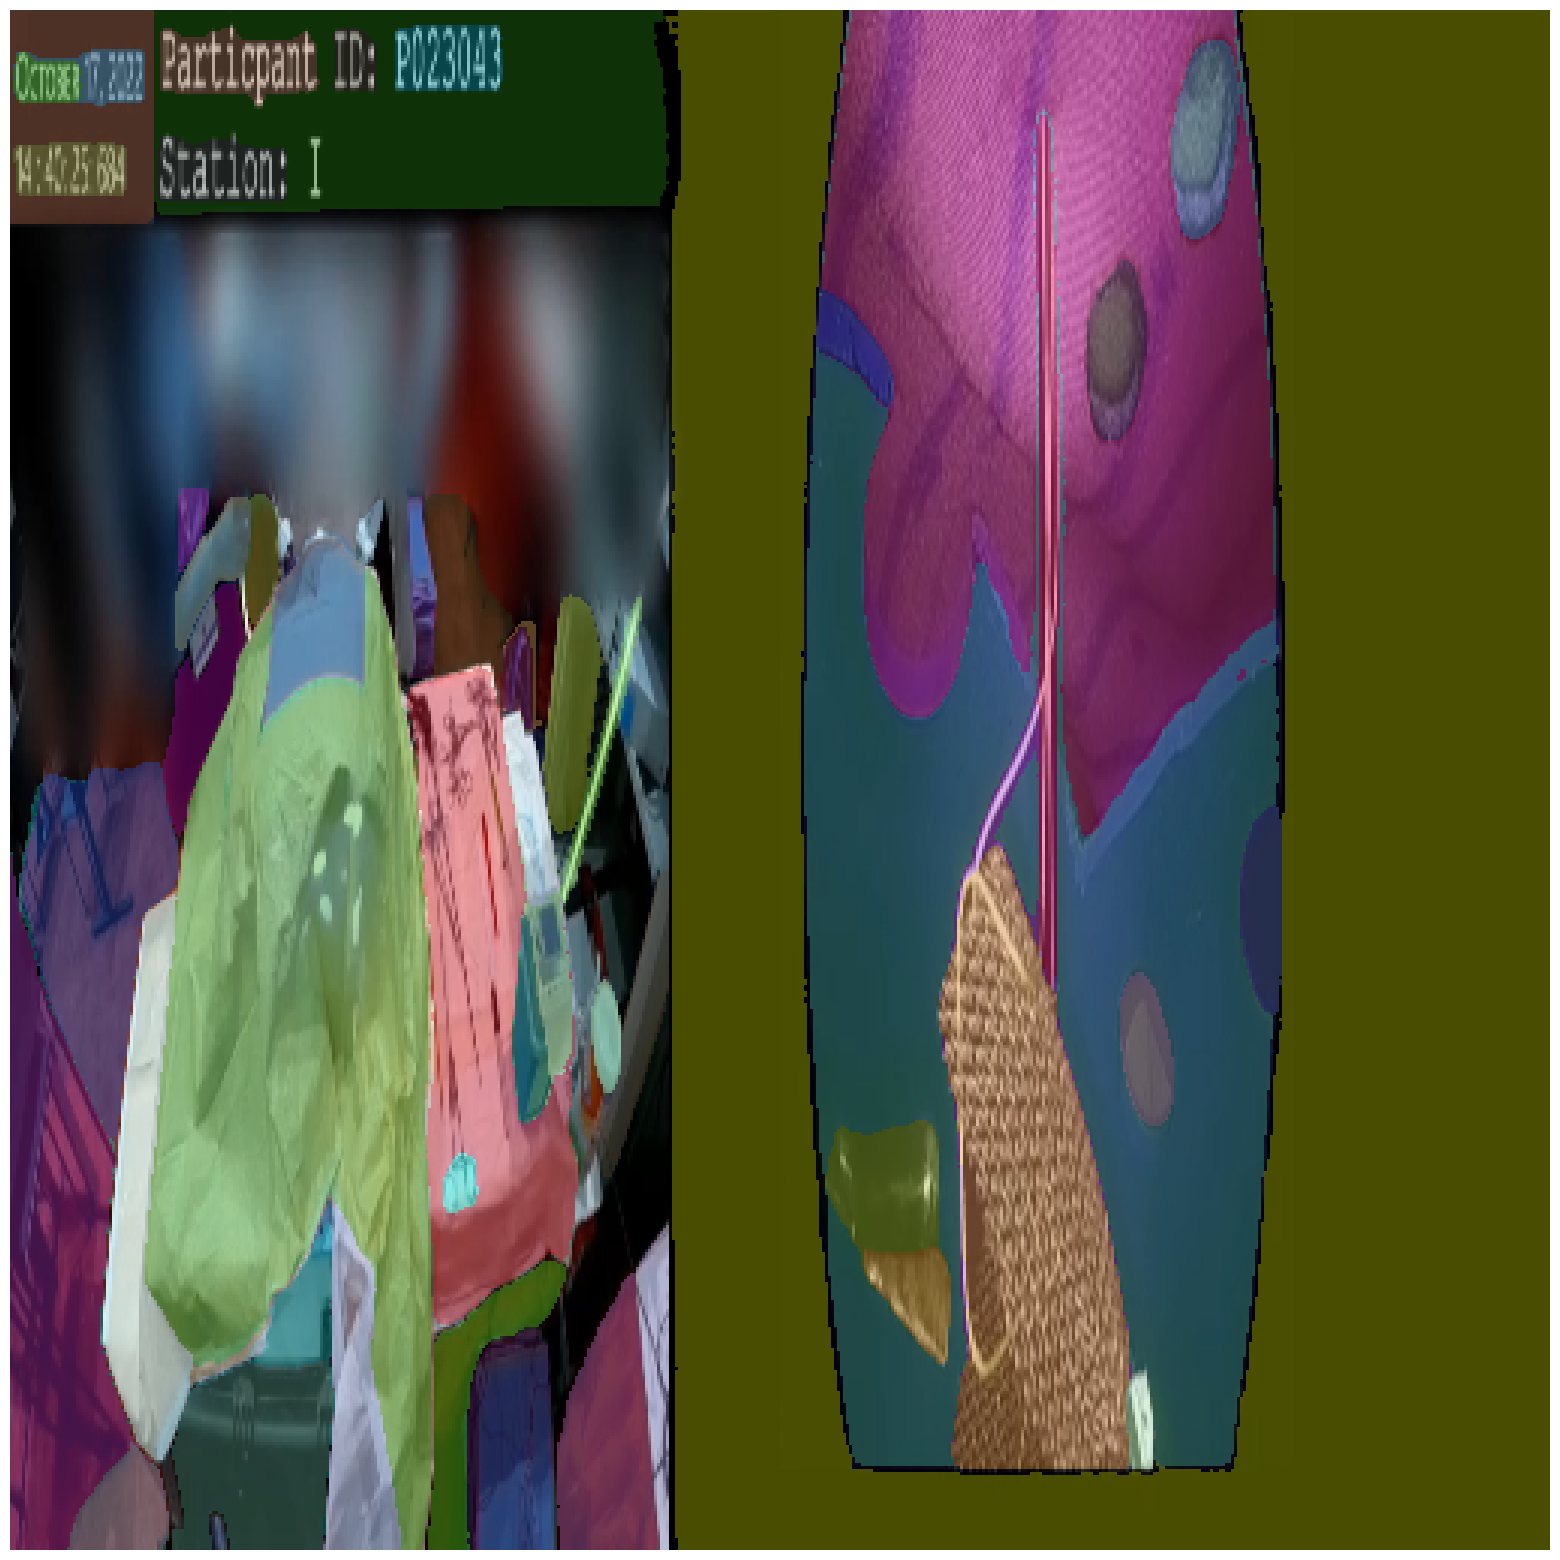

In [35]:
sam.generate_display_mask(video_frames[34])

In [27]:
query_negative = "photo of a two sided video feed of a surgeon performing a practice surgery with an endoscopic camera"
query_positive = "photo of a two sided video feed of a surgeon performing a practice surgery with an endoscopic camera. The surgeon is using a suturing needle"

In [28]:
response = clip_video_response()
negative_response = response.generate_response_curve(video_path=path, queries=[query_negative], sampling_rate=sampling_rate)[0]
positive_reponse = response.generate_response_curve(video_path=path, queries=[query_positive], sampling_rate=sampling_rate)[0]

filtered_negative_response = stats.zscore(savgol_filter(negative_response, 30, 3))
filtered_positive_reponse = stats.zscore(savgol_filter(positive_reponse, 30, 3))

difference_response = filtered_positive_reponse - filtered_negative_response


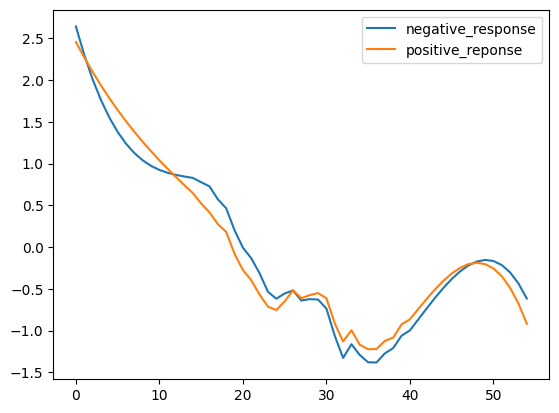

In [29]:
plt.plot(filtered_negative_response, label="negative_response")
plt.plot(filtered_positive_reponse, label="positive_reponse")
plt.legend()

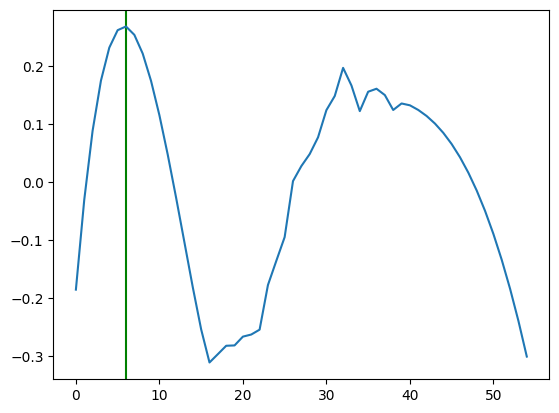

In [30]:
plt.axvline(x = np.argmax(difference_response), color = 'g', linestyle = '-')
plt.plot(difference_response)

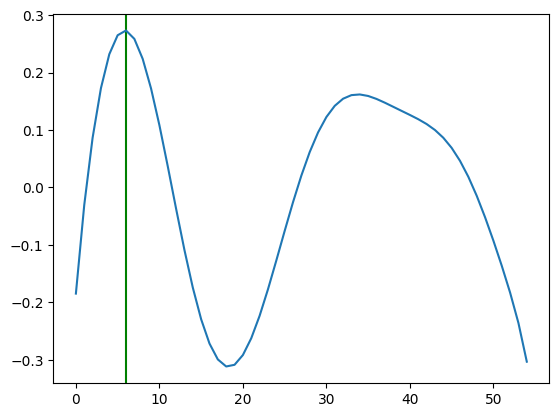

In [31]:
convex_curve = savgol_filter(difference_response, len(difference_response), 10)
plt.axvline(x = np.argmax(convex_curve), color = 'g', linestyle = '-')
plt.plot(convex_curve)

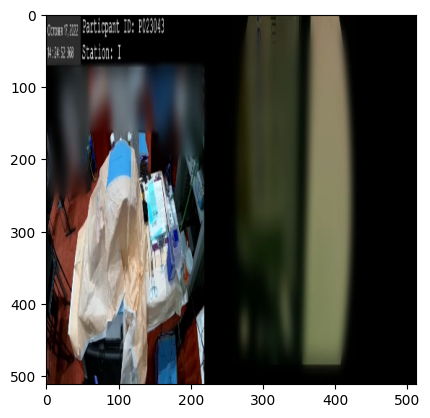

In [32]:
plt.imshow(video_frames[np.argmax(convex_curve)])

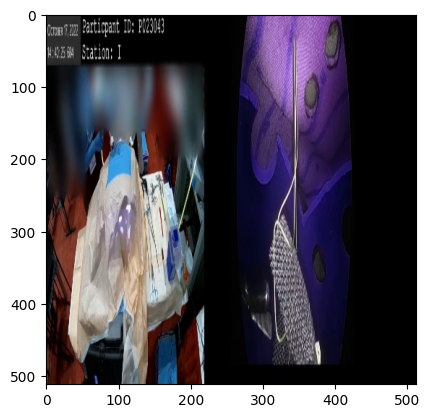

In [34]:
plt.imshow(video_frames[34])